{/* cspell:ignore prefactors */}

# Krylov quantum diagonalization of lattice Hamiltonians

*Usage estimate: 20 minutes on a Heron r2 (NOTE: This is an estimate only. Your runtime might vary.)*



## Background

This tutorial demonstrates how to implement the Krylov Quantum Diagonalization Algorithm (KQD) within the context of Qiskit patterns. You will first learn about the theory behind the algorithm and then see a demonstration of its execution on a QPU.

Across disciplines, we're interested in learning ground state properties of quantum systems. Examples include understanding the fundamental nature of particles and forces, predicting and understanding the behavior of complex materials and understanding bio-chemical interactions and reactions. Because of the exponential growth of the Hilbert space and the correlation that arise in entangled systems, classical algorithm struggle to solve this problem for quantum systems of increasing size. At one end of the spectrum is the existing approach that takes advantage of the quantum hardware focus on variational quantum methods (for example, [variational quantum eigensolver](/docs/tutorials/spin-chain-vqe)). These techniques face challenges with current devices because of the high number of function calls required in the optimization process, which adds a large overhead in resources once advanced error mitigation techniques are introduced, thus limiting their efficacy to small systems. At the other end of the spectrum, there are fault-tolerant quantum methods with performance guarantees (for example, [quantum phase estimation](https://arxiv.org/abs/quant-ph/0604193)), which require deep circuits that can be executed only on a fault-tolerant device. For these reasons, we introduce here a quantum algorithm based on subspace methods (as described in this [review paper](https://arxiv.org/abs/2312.00178)), the Krylov quantum diagonalization (KQD) algorithm. This algorithm performs well at large scale [\[1\]](#references) on existing quantum hardware, shares similar [performance guarantees](https://arxiv.org/abs/2110.07492) as phase estimation, is compatible with advanced error mitigation techniques, and could provide results that are classically inaccessible.



## Requirements

Before starting this tutorial, be sure you have the following installed:

*   Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
*   Qiskit Runtime 0.22 or later ( `pip install qiskit-ibm-runtime` )



## Setup



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from typing import Union, List
import itertools as it
import copy
from sympy import Matrix
import warnings

warnings.filterwarnings("ignore")

from qiskit.quantum_info import SparsePauliOp, Pauli, StabilizerState, Operator
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import Target, CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_coupling_map as pcm


from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorOptions,
    EstimatorV2 as Estimator,
)


def solve_regularized_gen_eig(
    h: np.ndarray,
    s: np.ndarray,
    threshold: float,
    k: int = 1,
    return_dimn: bool = False,
) -> Union[float, List[float]]:
    """
    Method for solving the generalized eigenvalue problem with regularization

    Args:
        h (numpy.ndarray):
            The effective representation of the matrix in the Krylov subspace
        s (numpy.ndarray):
            The matrix of overlaps between vectors of the Krylov subspace
        threshold (float):
            Cut-off value for the eigenvalue of s
        k (int):
            Number of eigenvalues to return
        return_dimn (bool):
            Whether to return the size of the regularized subspace

    Returns:
        lowest k-eigenvalue(s) that are the solution of the regularized generalized eigenvalue problem


    """
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array(
        [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
    )
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    if k == 1:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][0], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][0]
    else:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k]


def single_particle_gs(H_op, n_qubits):
    """
    Find the ground state of the single particle(excitation) sector
    """
    H_x = []
    for p, coeff in H_op.to_list():
        H_x.append(set([i for i, v in enumerate(Pauli(p).x) if v]))

    H_z = []
    for p, coeff in H_op.to_list():
        H_z.append(set([i for i, v in enumerate(Pauli(p).z) if v]))

    H_c = H_op.coeffs

    print("n_sys_qubits", n_qubits)

    n_exc = 1
    sub_dimn = int(sp.special.comb(n_qubits + 1, n_exc))
    print("n_exc", n_exc, ", subspace dimension", sub_dimn)

    few_particle_H = np.zeros((sub_dimn, sub_dimn), dtype=complex)

    sparse_vecs = [
        set(vec) for vec in it.combinations(range(n_qubits + 1), r=n_exc)
    ]  # list all of the possible sets of n_exc indices of 1s in n_exc-particle states

    m = 0
    for i, i_set in enumerate(sparse_vecs):
        for j, j_set in enumerate(sparse_vecs):
            m += 1

            if len(i_set.symmetric_difference(j_set)) <= 2:
                for p_x, p_z, coeff in zip(H_x, H_z, H_c):
                    if i_set.symmetric_difference(j_set) == p_x:
                        sgn = ((-1j) ** len(p_x.intersection(p_z))) * (
                            (-1) ** len(i_set.intersection(p_z))
                        )
                    else:
                        sgn = 0

                    few_particle_H[i, j] += sgn * coeff

    gs_en = min(np.linalg.eigvalsh(few_particle_H))
    print("single particle ground state energy: ", gs_en)
    return gs_en

## Step 1: Map classical inputs to a quantum problem



### The Krylov space

The Krylov space $\mathcal{K}^r$ of order $r$ is the space spanned by vectors obtained by multiplying higher powers of a matrix $A$, up to $r-1$, with a reference vector $\vert v \rangle$.

$$
\mathcal{K}^r = \left\{ \vert v \rangle, A \vert v \rangle, A^2 \vert v \rangle, ..., A^{r-1} \vert v \rangle \right\}
$$

If the matrix $A$ is the Hamiltonian $H$, we'll refer to the corresponding space as the power Krylov space $\mathcal{K}_P$. In the case where $A$ is the time-evolution operator generated by the Hamiltonian $U=e^{-iHt}$, we'll refer to the space as the unitary Krylov space $\mathcal{K}_U$. The power Krylov subspace that we use classically cannot be generated directly on a quantum computer as $H$ is not a unitary operator. Instead, we can use the time-evolution operator $U = e^{-iHt}$ which can be shown to give similar [convergence guarantees](https://arxiv.org/abs/2110.07492) as the power method. Powers of $U$ then become different time steps $U^k = e^{-iH(kt)}$.

$$
\mathcal{K}_U^r = \left\{ \vert \psi \rangle, U \vert \psi \rangle, U^2 \vert \psi \rangle, ..., U^{r-1} \vert \psi \rangle \right\}
$$

See the Appendix for a detailed derivation of how the unitary Krylov space allows to represents low-energy eigenstates accurately.



### Krylov quantum diagonalization algorithm

Given an Hamiltonian $H$ that we wish to diagonalize, first we consider the corresponding unitary Krylov space $\mathcal{K}_U$. The goal is to find a compact representation of the Hamiltonian in $\mathcal{K}_U$, which we'll refer to as $\tilde{H}$. The matrix elements of $\tilde{H}$, the projection of the Hamiltonian in the Krylov space, can be calculated by calculating the following expectation values

$$
\tilde{H}_{mn} = \langle \psi_m \vert H \vert \psi_n \rangle =
$$

$$
= \langle \psi \vert  e^{i H t_m}   H e^{-i H t_n} \vert \psi \rangle
$$

$$
= \langle \psi \vert  e^{i H m dt}   H e^{-i H n dt} \vert \psi \rangle
$$

Where $\vert \psi_n \rangle = e^{-i H t_n} \vert \psi \rangle$ are the vectors of the unitary Krylov space and $t_n = n dt$ are the multiples of the time step $dt$ chosen. On a quantum computer, the calculation of each matrix elements can be done with any algorithm which allows to obtain overlap between quantum states. This tutorial focuses on the Hadamard test. Given that the $\mathcal{K}_U$ has dimension $r$, the Hamiltonian projected into the subspace will have dimensions $r \times r$. With $r$ small enough (generally $r<<100$ is sufficient to obtain convergence of estimates of eigenenergies) we can then easily diagonalize the projected Hamiltonian $\tilde{H}$. However, we cannot directly diagonalize $\tilde{H}$ because of the non-orthogonality of the Krylov space vectors. We'll have to measure their overlaps and construct a matrix $\tilde{S}$

$$
\tilde{S}_{mn} = \langle \psi_m \vert \psi_n \rangle
$$

This allows us to solve the eigenvalue problem in a non-orthogonal space (also called generalized eigenvalue problem)

$$
\tilde{H} \ \vec{c} = E \ \tilde{S} \ \vec{c}
$$

One can then obtain estimates of the eigenvalues and eigenstates of $H$ by looking at the ones of $\tilde{H}$. For example, the estimate of the ground state energy is obtained by taking the smallest eigenvalue $c$ and the ground state from the corresponding eigenvector $\vec{c}$. The coefficients in $\vec{c}$ determines the contribution of the different vectors that span $\mathcal{K}_U$.

<img src="images/M-HT.png" alt="fig1.png" style="display: block; margin: auto;">

The Figure shows a circuit representation of the modified Hadamard test, a method that is used to compute the overlap between different quantum states. For each matrix element $\tilde{H}_{i,j}$, a Hadamard test between the state $\vert \psi_i \rangle$, $\vert \psi_j \rangle$ is carried out. This is highlighted in the figure by the color scheme for the matrix elements and the corresponding $\text{Prep} \; \psi_i$, $\text{Prep} \; \psi_j$ operations. Thus, a set of Hadamard tests for all the possible combinations of Krylov space vectors is required to compute all the matrix elements of the projected Hamiltonian $\tilde{H}$. The top wire in the Hadamard test circuit is an ancilla qubit which is measured either in the X or Y basis, its expectation value determines the value of the overlap between the states. The bottom wire represents all the qubits of the system Hamiltonian. The $\text{Prep} \; \psi_i$ operation prepares the system qubit in the state $\vert \psi_i \rangle$ controlled by the state of the ancilla qubit (similarly for $\text{Prep} \; \psi_j$) and the operation $P$ represents Pauli decomposition of the system Hamiltonian $H = \sum_i P_i$. A more detailed derivation of the operations calculated by the Hadamard test is given below.



#### Define Hamiltonian

Let's consider the Heisenberg Hamiltonian for $N$ qubits on a linear chain: $H= \sum_{i,j}^N X_i X_j + Y_i Y_j - J Z_i Z_j$



In [2]:
# Define problem Hamiltonian.
n_qubits = 6
J = 1  # coupling strength for ZZ interaction

# Define the Hamiltonian:
H_int = [["I"] * n_qubits for _ in range(3 * (n_qubits - 1))]
for i in range(n_qubits - 1):
    H_int[i][i] = "Z"
    H_int[i][i + 1] = "Z"
for i in range(n_qubits - 1):
    H_int[n_qubits - 1 + i][i] = "X"
    H_int[n_qubits - 1 + i][i + 1] = "X"
for i in range(n_qubits - 1):
    H_int[2 * (n_qubits - 1) + i][i] = "Y"
    H_int[2 * (n_qubits - 1) + i][i + 1] = "Y"
H_int = ["".join(term) for term in H_int]
H_tot = [(term, J) if term.count("Z") == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
print(H_tot)

[('ZZIIII', 1), ('IZZIII', 1), ('IIZZII', 1), ('IIIZZI', 1), ('IIIIZZ', 1), ('XXIIII', 1), ('IXXIII', 1), ('IIXXII', 1), ('IIIXXI', 1), ('IIIIXX', 1), ('YYIIII', 1), ('IYYIII', 1), ('IIYYII', 1), ('IIIYYI', 1), ('IIIIYY', 1)]


Heisenberg Spin Chain Hamiltonian matrix:

In [3]:
np.set_printoptions(threshold=np.inf)
Ham = Operator(H_op).data.real
# print(Ham)

For the modified Hadamard test with the same controlled initialization before and after the time evolution, the vacuum state $|00\dots0\rangle = \begin{bmatrix}1 \\
0 \\
\vdots \\
0\end{bmatrix}$ must be an eigenvector of the system Hamiltonian. This also means $H|0\rangle = E_0|0\rangle$ where $E_0$ is the eigenvalue of the vacuum state and $|0\rangle$ is the vacuum state.

In [4]:
# e, v = sp.linalg.eig(Ham)

# print('vals', e)
# print('vecs \n', v)


In [5]:
# zero = np.array([[1],[0]])
# vac = zero
# for _ in range(n_qubits - 1):
#     vac = np.kron(vac, zero)
# print(Ham@vac)

#### Set parameters for the algorithm



We heuristically choose a value for the time-step `dt` (based on upper bounds on the Hamiltonian norm). Ref [\[2\]](#references)  showed that a sufficiently small timestep is $\pi/\vert \vert H \vert \vert$, and that it is preferable up to a point to underestimate this value rather than overestimate, since overestimating can allow contributions from high-energy states to corrupt even the optimal state in the Krylov space. On the other hand, choosing $dt$ to be too small leads to worse conditioning of the Krylov subspace, since the Krylov basis vectors differ less from timestep to timestep.

In [6]:
# Get Hamiltonian restricted to single-particle states
single_particle_H = np.zeros((n_qubits, n_qubits))
for i in range(n_qubits):
    for j in range(i + 1):
        for p, coeff in H_op.to_list():
            p_x = Pauli(p).x
            p_z = Pauli(p).z
            if all(
                p_x[k] == ((i == k) + (j == k)) % 2 for k in range(n_qubits)
            ):
                sgn = (
                    (-1j) ** sum(p_z[k] and p_x[k] for k in range(n_qubits))
                ) * ((-1) ** p_z[i])
            else:
                sgn = 0
            single_particle_H[i, j] += sgn * coeff
for i in range(n_qubits):
    for j in range(i + 1, n_qubits):
        single_particle_H[i, j] = np.conj(single_particle_H[j, i])

# Set dt according to spectral norm
dt = np.pi / np.linalg.norm(single_particle_H, ord=2)
dt

np.float64(0.6283185307179586)

And set other parameters of the algorithm. For the sake of this tutorial, we'll limit ourselves to using a Krylov space with only five dimensions, which is quite limiting.



In [7]:
# Set parameters for quantum Krylov algorithm
krylov_dim = 5  # size of Krylov subspace
num_trotter_steps = 6
dt_circ = dt / num_trotter_steps

#### State preparation

Pick a reference state $\vert \psi \rangle$ that has some overlap with the ground state. For this Hamiltonian, We use the a state with an excitation in the middle qubit $\vert 00..010...00 \rangle$ as our reference state.



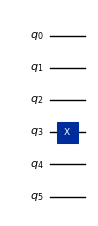

In [8]:
qc_state_prep = QuantumCircuit(n_qubits)
qc_state_prep.x(int(n_qubits / 2))
qc_state_prep.draw("mpl", scale=0.5)

#### Time evolution

We can realize the time-evolution operator generated by a given Hamiltonian: $U=e^{-iHt}$ via the [Lie-Trotter approximation](/docs/api/qiskit/qiskit.synthesis.LieTrotter).



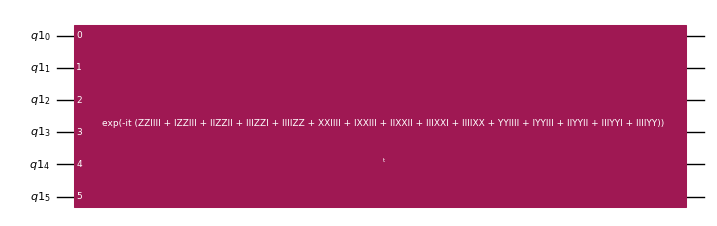

In [9]:
t = Parameter("t")

## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(
    H_op, time=t, synthesis=LieTrotter(reps=num_trotter_steps)
)

qr = QuantumRegister(n_qubits)
qc_evol = QuantumCircuit(qr)
qc_evol.append(evol_gate, qargs=qr)
qc_evol.draw("mpl", scale=0.5)

#### Hadamard test

<img src="images/M-HT-circ.png" alt="fig2.png" style="display: block; margin: auto;">


$$
\begin{equation*}
    |0\rangle|0\rangle^N \quad\longrightarrow\quad \frac{1}{\sqrt{2}}\Big(|0\rangle + |1\rangle \Big)|0\rangle^N \quad\longrightarrow\quad \frac{1}{\sqrt{2}}\Big(|0\rangle|0\rangle^N+|1\rangle |\psi_i\rangle\Big) \quad\longrightarrow\quad \frac{1}{\sqrt{2}}\Big(|0\rangle |0\rangle^N+|1\rangle P |\psi_i\rangle\Big) \quad\longrightarrow\quad\frac{1}{\sqrt{2}}\Big(|0\rangle |\psi_j\rangle+|1\rangle P|\psi_i\rangle\Big)
\end{equation*}
$$

Where $P$ is one of the terms in the decomposition of the Hamiltonian $H=\sum P$ and $\text{Prep} \; \psi_i$, $\text{Prep} \; \psi_j$ are controlled operations that prepare $|\psi_i\rangle$, $|\psi_j\rangle$ vectors of the unitary Krylov space, with $|\psi_k\rangle = e^{-i H k dt } \vert \psi \rangle = e^{-i H k dt } U_{\psi} \vert 0 \rangle^N$. To measure $X$, first apply $H$...

$$
\begin{equation*}
    \longrightarrow\quad\frac{1}{2}|0\rangle\Big( |\psi_j\rangle + P|\psi_i\rangle\Big) + \frac{1}{2}|1\rangle\Big(|\psi_j\rangle - P|\psi_i\rangle\Big)
\end{equation*}
$$

... then measure:

$$
\begin{equation*}
\begin{split}
    \Rightarrow\quad\langle X\rangle &= \frac{1}{4}\Bigg(\Big\|| \psi_j\rangle + P|\psi_i\rangle \Big\|^2-\Big\||\psi_j\rangle - P|\psi_i\rangle\Big\|^2\Bigg) \\
    &= \text{Re}\Big[\langle\psi_j| P|\psi_i\rangle\Big].
\end{split}
\end{equation*}
$$

From the identity $|a + b\|^2 = \langle a + b | a + b \rangle = \|a\|^2 + \|b\|^2 + 2\text{Re}\langle a | b \rangle$. Similarly, measuring $Y$ yields

$$
\begin{equation*}
    \langle Y\rangle = \text{Im}\Big[\langle\psi_j| P|\psi_i\rangle\Big].
\end{equation*}
$$



Circuit for calculating the real part of the overlap in S via Hadamard test


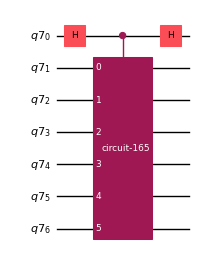

In [10]:
## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(
    H_op, time=dt, synthesis=LieTrotter(reps=num_trotter_steps)
)

## Create the time-evo op dagger circuit
evol_gate_d = PauliEvolutionGate(
    H_op, time=dt, synthesis=LieTrotter(reps=num_trotter_steps)
)
evol_gate_d = evol_gate_d.inverse()

# Put pieces together
qc_reg = QuantumRegister(n_qubits)
qc_temp = QuantumCircuit(qc_reg)
qc_temp.compose(qc_state_prep, inplace=True)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate, qargs=qc_reg)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate_d, qargs=qc_reg)
qc_temp.compose(qc_state_prep.inverse(), inplace=True)

# Create controlled version of the circuit
controlled_U = qc_temp.to_gate().control(1)

# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits + 1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.append(controlled_U, list(range(n_qubits + 1)))
qc_real.h(0)

print(
    "Circuit for calculating the real part of the overlap in S via Hadamard test"
)
qc_real.draw("mpl", fold=-1, scale=0.5)

The Hadamard test circuit can be a deep circuit once we decompose to native gates (which will increase even more if we account for the topology of the device)



In [11]:
print(
    "Number of layers of 2Q operations",
    qc_real.decompose(reps=2).depth(lambda x: x[0].num_qubits == 2),
)

Number of layers of 2Q operations 20881


## Step 2: Optimize problem for quantum hardware execution

### Efficient Hadamard test

We can optimize the deep circuits for the Hadamard test that we have obtained by introducing some approximations and relying on some assumption about the model Hamiltonian. For example, consider the following circuit for the Hadamard test:

<img src="images/New-M-HT.png" alt="fig3.png" style="display: block; margin: auto;">

Assume we can classically calculate $E_0$, the eigenvalue of $|0\rangle^N$ under the Hamiltonian $H$.
This is satisfied when the Hamiltonian preserves the U(1) symmetry. Although this may seem like a strong assumption, there are many cases where it is safe to assume that there is a vacuum state (in this case it maps to the $|0\rangle^N$ state) which is unaffected by the action of the Hamiltonian. This is true for example for chemistry Hamiltonians that describe stable molecule (where the number of electrons is conserved).
Given that the gate $\text{Prep} \; \psi$, prepares the desired reference state $\ket{\psi} = \text{Prep} \; \psi \ket{0} = e^{-i H 0 dt} U_{\psi} \ket{0}$, for example, to prepare the HF state for chemistry $\text{Prep} \; \psi$ would be a product of single-qubit NOTs, so controlled-$\text{Prep} \; \psi$ is just a product of CNOTs.
Then the circuit above implements the following state prior to measurement:

$$
\begin{equation}
\begin{split}
    \ket{0} \ket{0}^N\xrightarrow{H}&\frac{1}{\sqrt{2}}
    \left(
    \ket{0}\ket{0}^N+ \ket{1} \ket{0}^N
    \right)\\
    \xrightarrow{\text{1-ctrl-init}}&\frac{1}{\sqrt{2}}\left(|0\rangle|0\rangle^N+|1\rangle|\psi\rangle\right)\\
    \xrightarrow{U}&\frac{1}{\sqrt{2}}\left(e^{i\phi}\ket{0}\ket{0}^N+\ket{1} U\ket{\psi}\right)\\
    \xrightarrow{\text{0-ctrl-init}}&\frac{1}{\sqrt{2}}
    \left(
    e^{i\phi}\ket{0} \ket{\psi}
    +\ket{1} U\ket{\psi}
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+}\left(e^{i\phi}\ket{\psi}+U\ket{\psi}\right)
    +\ket{-}\left(e^{i\phi}\ket{\psi}-U\ket{\psi}\right)
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+i}\left(e^{i\phi}\ket{\psi}-iU\ket{\psi}\right)
    +\ket{-i}\left(e^{i\phi}\ket{\psi}+iU\ket{\psi}\right)
    \right)
\end{split}
\end{equation}
$$

where we have used the classical simulable phase shift $ U\ket{0}^N = e^{i\phi}\ket{0}^N$ in the third line. Therefore the expectation values are obtained as

$$
\begin{equation}
\begin{split}
    \langle X\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi}+\bra{\psi}U^\dagger\right)P\left(e^{i\phi}\ket{\psi}+U\ket{\psi}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi}-\bra{\psi}U^\dagger\right)P\left(e^{i\phi}\ket{\psi}-U\ket{\psi}\right)
    \Big)\\
    &=\text{Re}\left[e^{-i\phi}\bra{\psi}PU\ket{\psi}\right],
\end{split}
\end{equation}
$$

$$
\begin{equation}
\begin{split}
    \langle Y\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi}+i\bra{\psi}U^\dagger\right)P\left(e^{i\phi}\ket{\psi}-iU\ket{\psi}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi}-i\bra{\psi}U^\dagger\right)P\left(e^{i\phi}\ket{\psi}+iU\ket{\psi}\right)
    \Big)\\
    &=\text{Im}\left[e^{-i\phi}\bra{\psi}PU\ket{\psi}\right].
\end{split}
\end{equation}
$$

Using these assumptions we were able to write the expectation values of operators of interest with fewer controlled operations. In fact, we only need to implement the controlled state preparation $\text{Prep} \; \psi$ and not controlled time evolutions. Reframing our calculation as above will allow us to greatly reduce the depth of the resulting circuits.



### Decompose time-evolution operator with Trotter decomposition

Instead of implementing the time-evolution operator exactly we can use the Trotter decomposition to implement an approximation of it. Repeating several times a certain order Trotter decomposition gives us further reduction of the error introduced from the approximation. In the following, we directly build the Trotter implementation in the most efficient way for the interaction graph of the Hamiltonian we are considering (nearest neighbor interactions only). In practice we insert Pauli rotations $R_{xx}$, $R_{yy}$, $R_{zz}$ with a parametrized angle $t$ which correspond to the approximate implementation of $e^{-i (XX + YY + ZZ) t}$. Given the difference in definition of the Pauli rotations and the time-evolution that we are trying to implement, we'll have to use the parameter $2*dt$ to achieve a time-evolution of $dt$. Furthermore, we reverse the order of the operations for odd number of repetitions of the Trotter steps, which is functionally equivalent but allows for synthesizing adjacent operations in a single $SU(2)$ unitary. This gives a much shallower circuit than what is obtained using the generic `PauliEvolutionGate()` functionality.



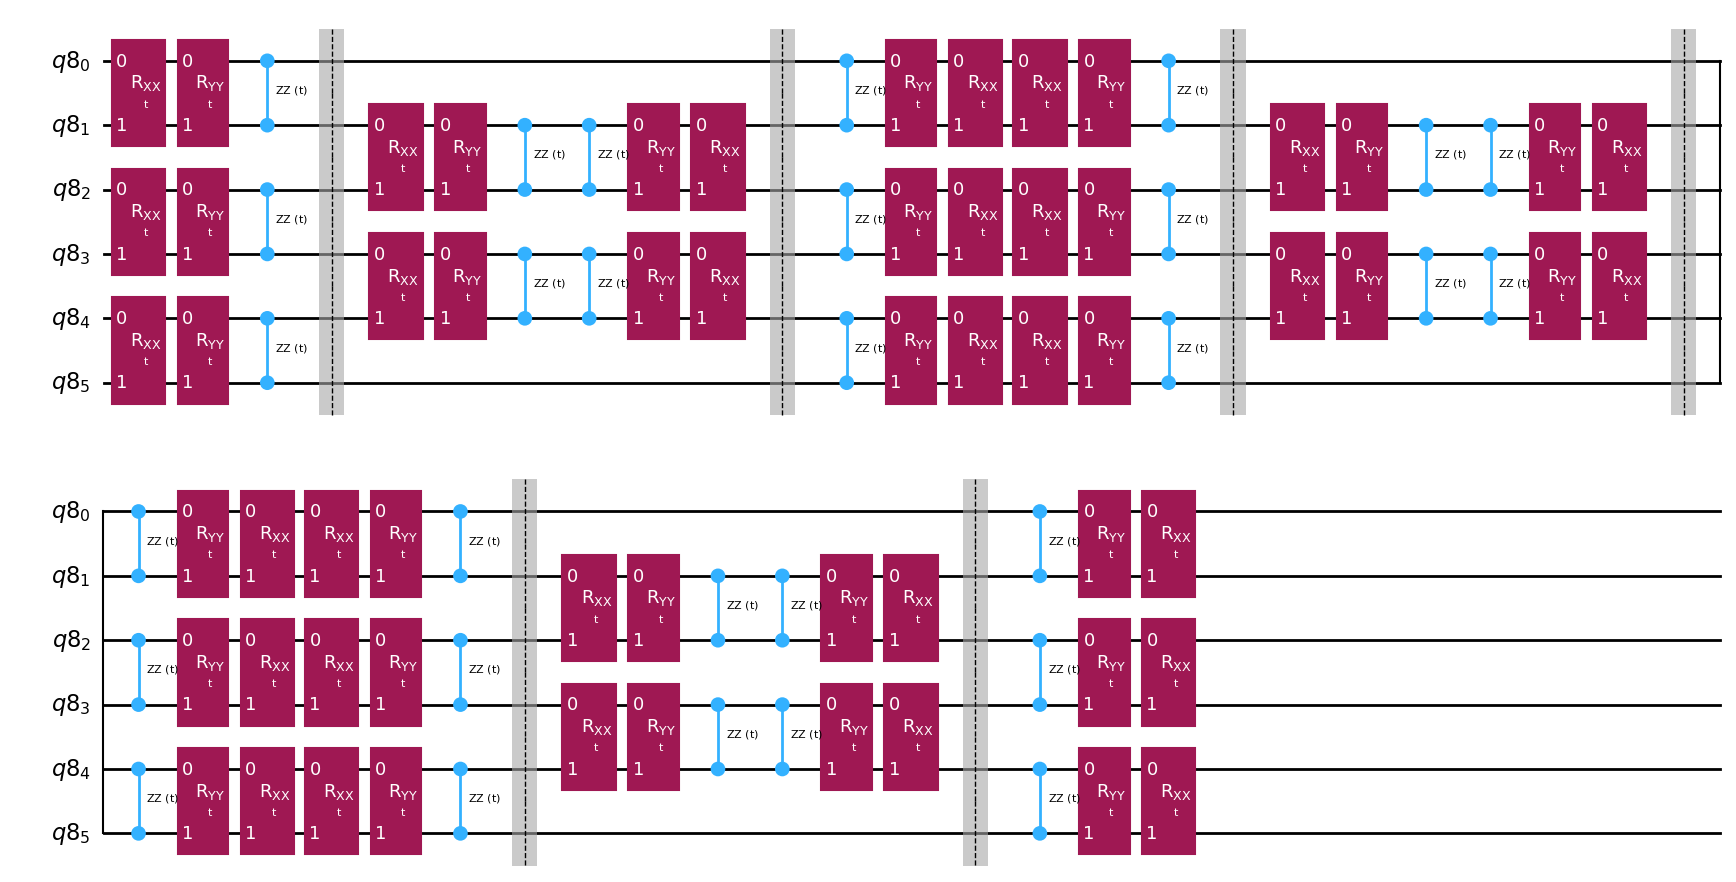

In [12]:
t = Parameter("t")

# Create instruction for rotation about XX+YY-ZZ:
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(t, 0, 1)
Rxyz_circ.ryy(t, 0, 1)
Rxyz_circ.rzz(t, 0, 1)
Rxyz_instr = Rxyz_circ.to_instruction(label="RXX+YY+ZZ")

interaction_list = [
    [[i, i + 1] for i in range(0, n_qubits - 1, 2)],
    [[i, i + 1] for i in range(1, n_qubits - 1, 2)],
]  # linear chain

qr = QuantumRegister(n_qubits)
trotter_step_circ = QuantumCircuit(qr)
for i, color in enumerate(interaction_list):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)
    if i < len(interaction_list) - 1:
        trotter_step_circ.barrier()
reverse_trotter_step_circ = trotter_step_circ.reverse_ops()

qc_evol = QuantumCircuit(qr)
for step in range(num_trotter_steps):
    if step % 2 == 0:
        qc_evol = qc_evol.compose(trotter_step_circ)
    else:
        qc_evol = qc_evol.compose(reverse_trotter_step_circ)

qc_evol.decompose().draw("mpl")

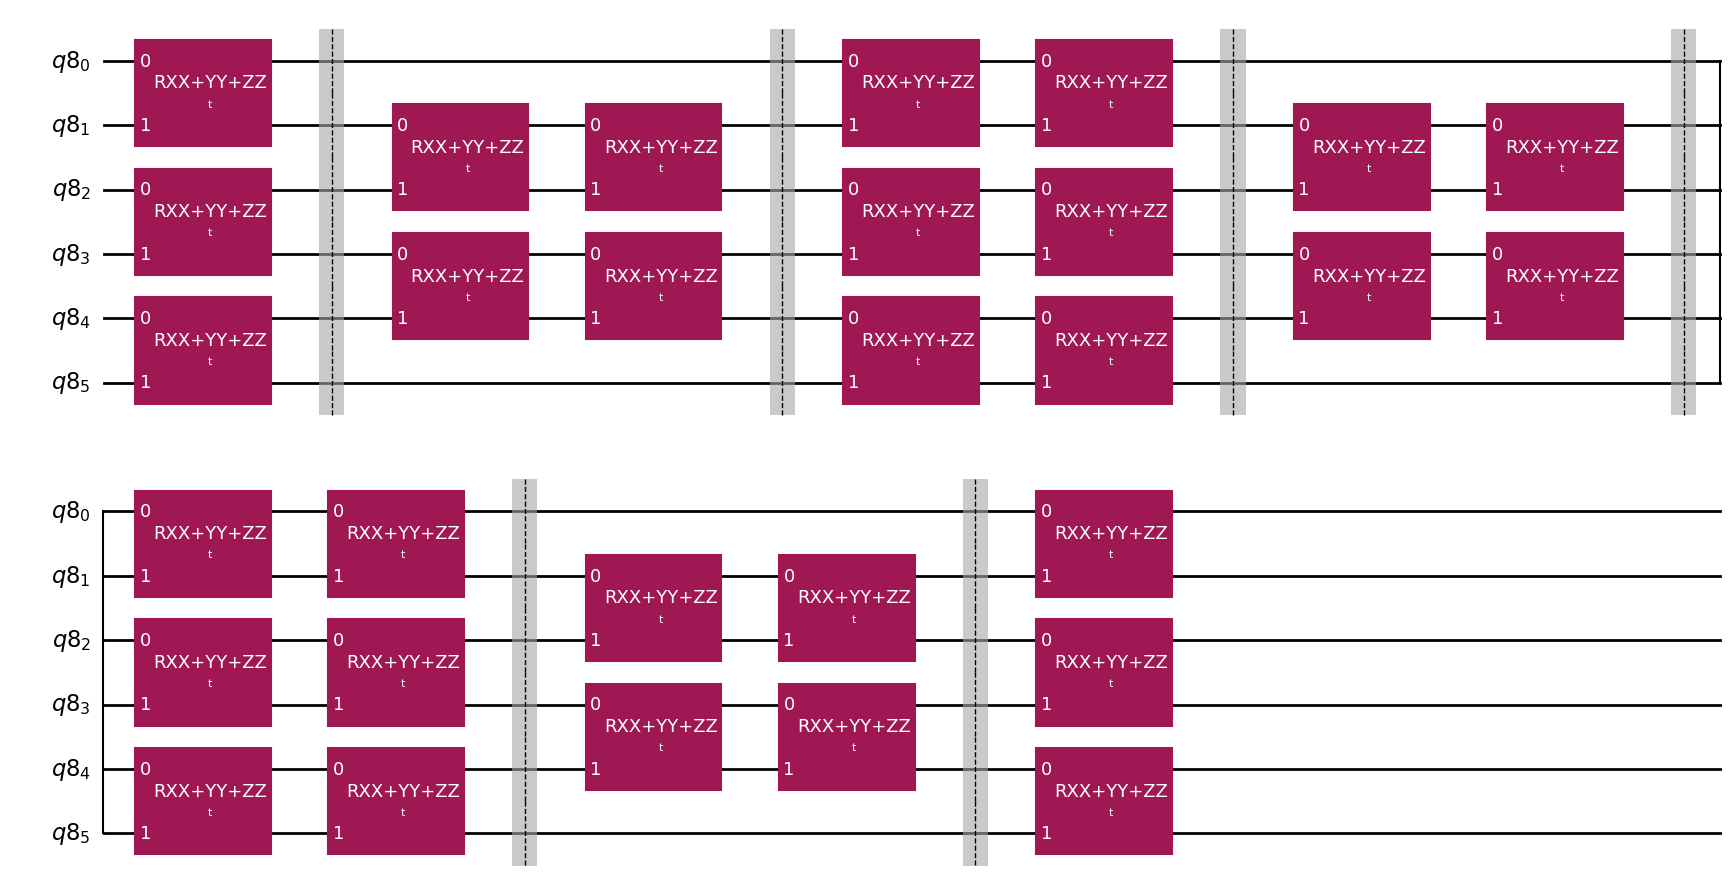

In [13]:
qc_evol.draw("mpl")

Above: Trotterized time evolution operator for
 $$H= \sum_{i,j}^N X_i X_j + Y_i Y_j - J Z_i Z_j$$

### Use an optimized circuit for state preparation



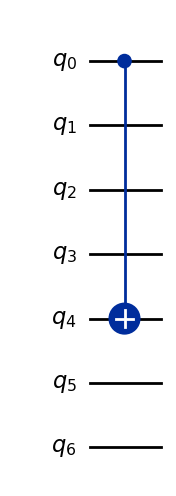

In [14]:
control = 0
excitation = int(n_qubits / 2) + 1
controlled_state_prep = QuantumCircuit(n_qubits + 1)
controlled_state_prep.cx(control, excitation)
controlled_state_prep.draw("mpl")

### Template circuits for calculating matrix elements of $\tilde{S}$ and $\tilde{H}$ via Hadamard test

The only difference between the circuits used in the Hadamard test will be the phase in the time-evolution operator and the observables measured. Therefore we can prepare a template circuit which represent the generic circuit for the Hadamard test, with placeholders for the gates that depend on the time-evolution operator.



In [15]:
# Parameters for the template circuits
parameters = []
for idx in range(1, krylov_dim):
    parameters.append(2 * dt_circ * (idx))

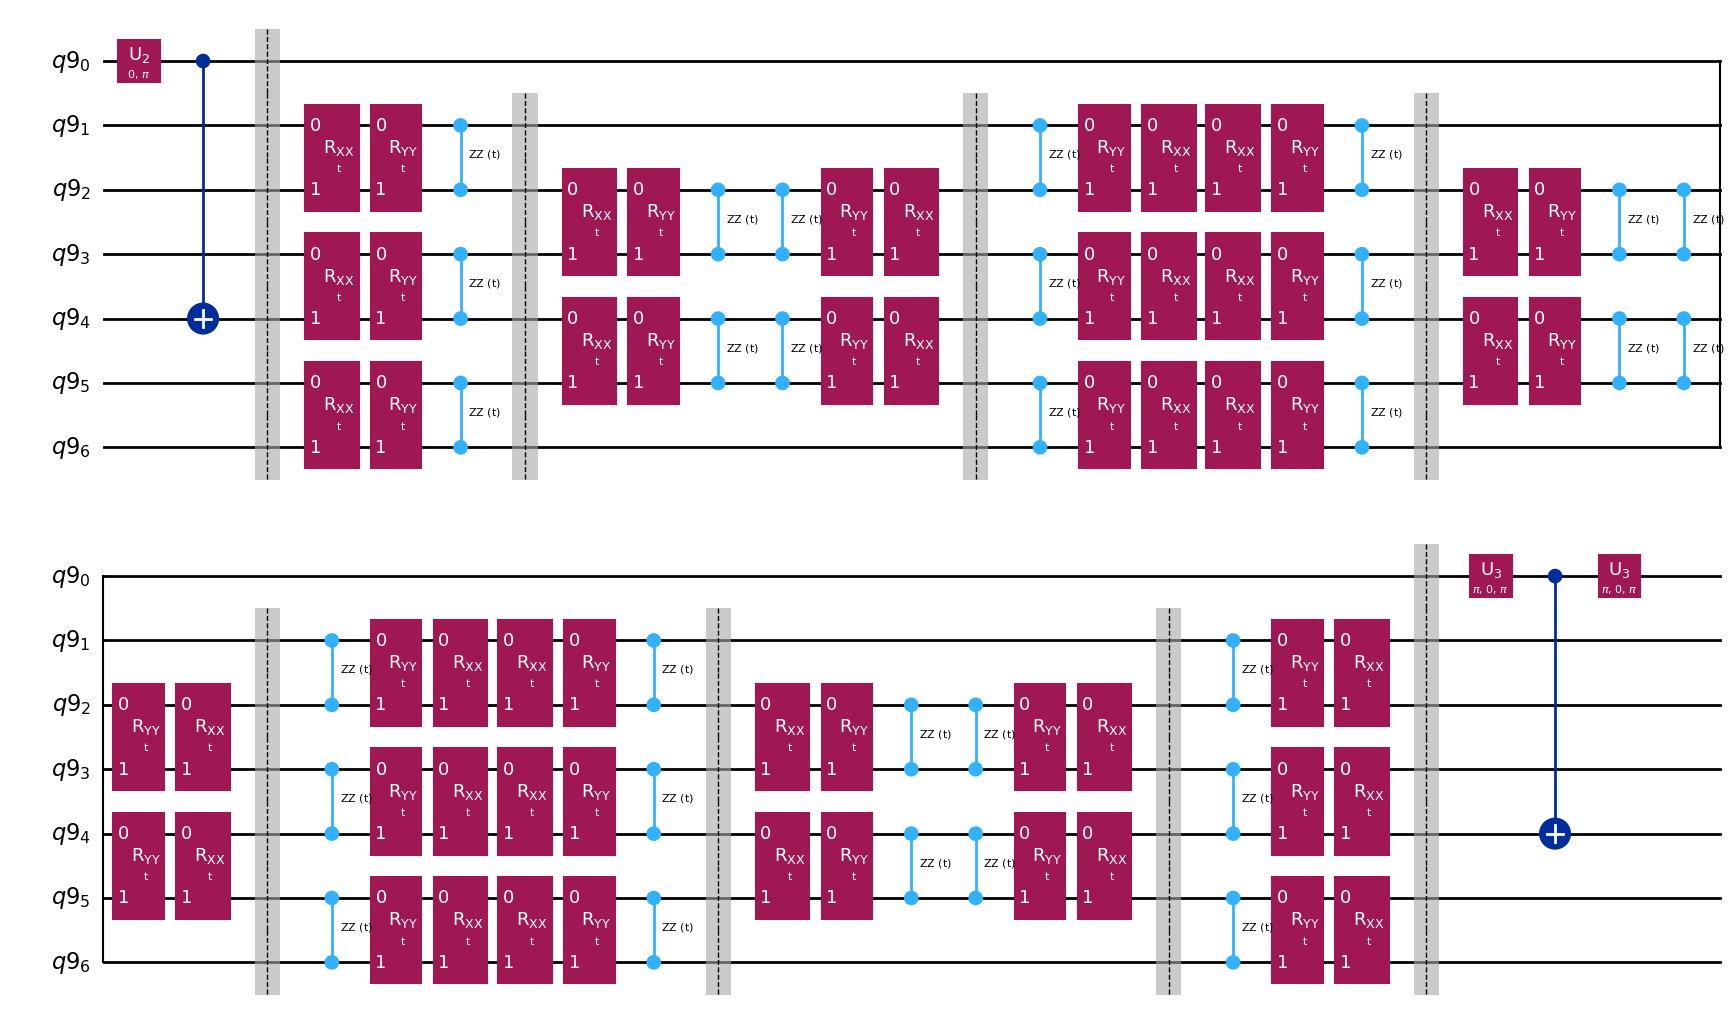

In [16]:
# Create modified hadamard test circuit
qr = QuantumRegister(n_qubits + 1)
qc = QuantumCircuit(qr)
qc.h(0)
qc.compose(controlled_state_prep, list(range(n_qubits + 1)), inplace=True)
qc.barrier()
qc.compose(qc_evol, list(range(1, n_qubits + 1)), inplace=True)
qc.barrier()
qc.x(0)
qc.compose(
    controlled_state_prep.inverse(), list(range(n_qubits + 1)), inplace=True
)
qc.x(0)

qc.decompose().draw("mpl")

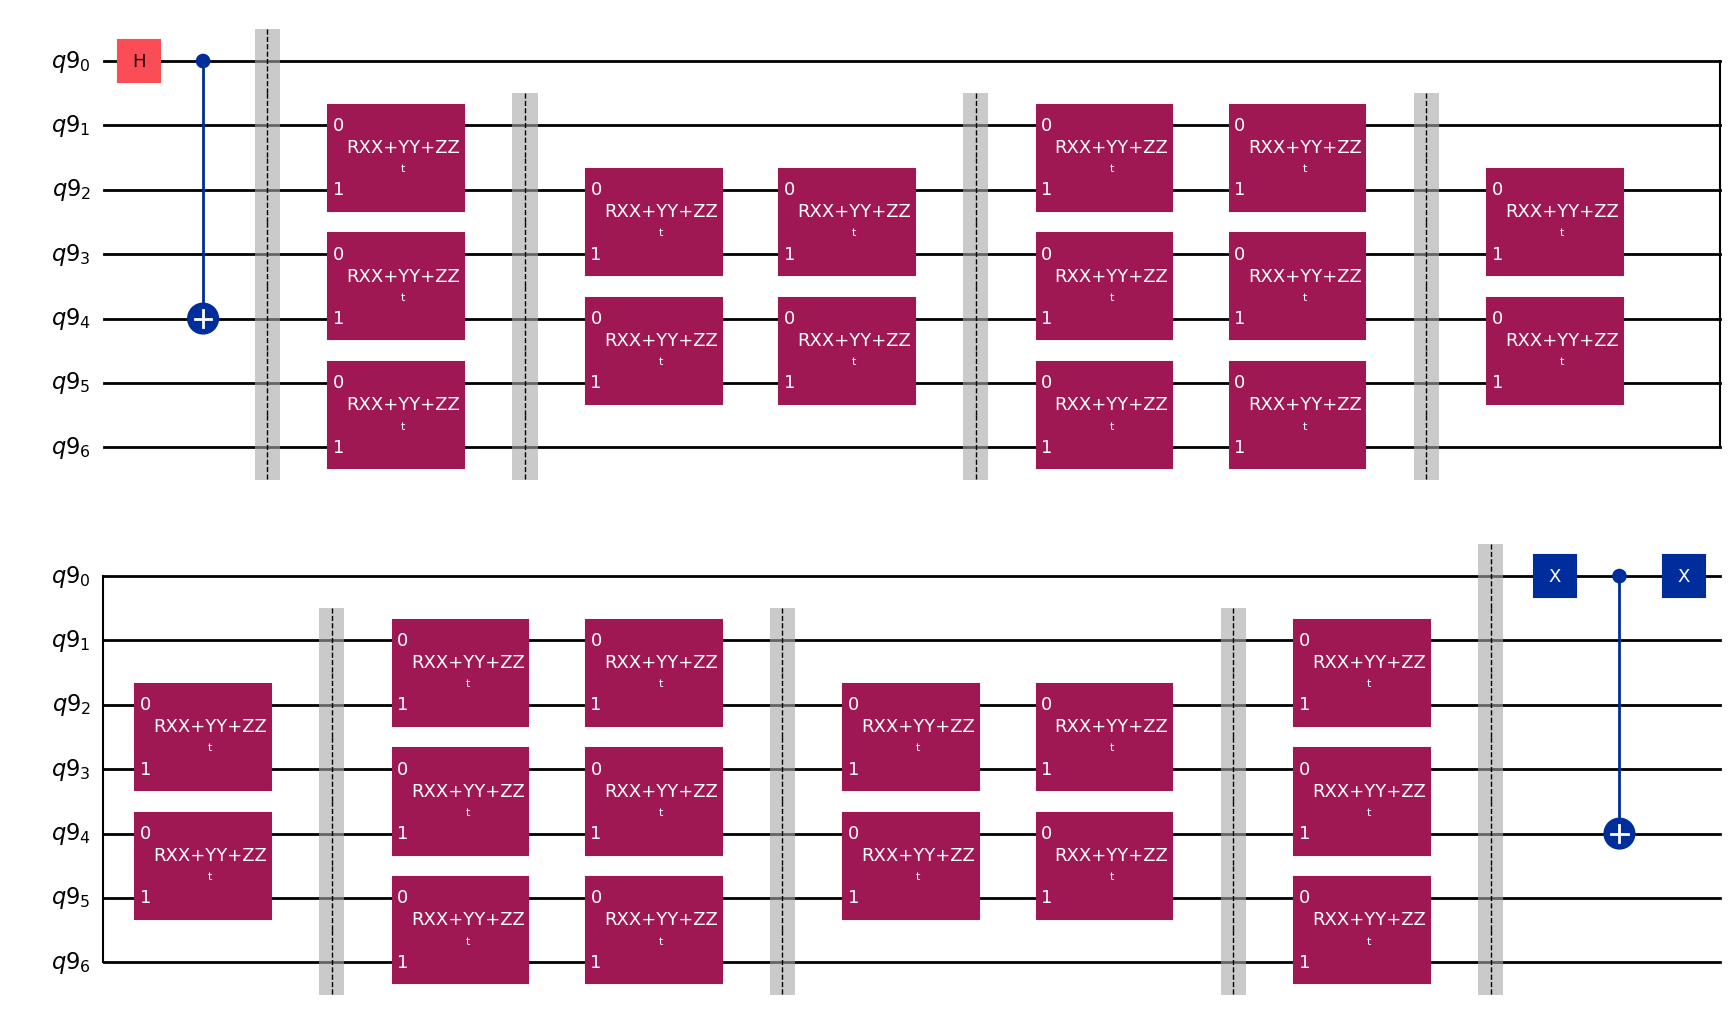

In [17]:
qc.draw("mpl")

In [18]:
print(
    "The optimized circuit has 2Q gates depth: ",
    qc.decompose().decompose().depth(lambda x: x[0].num_qubits == 2),
)

The optimized circuit has 2Q gates depth:  74


We have considerably reduced the depth of the Hadamard test with a combination of Trotter approximation and uncontrolled unitaries



## Step 3: Execute using Qiskit primitives



In [19]:
import rustworkx as rx
from rustworkx.visualization import graphviz_draw
from qiskit.exceptions import QiskitError
import math

def plot_coupling_map(
    num_qubits: int,
    qubit_coordinates: List[List[int]],
    coupling_map: List[List[int]],
    figsize=None,
    plot_directed=False,
    label_qubits=True,
    qubit_size=None,
    line_width=4,
    font_size=None,
    qubit_color=None,
    qubit_labels=None,
    line_color=None,
    font_color="white",
    ax=None,
    filename=None,
    *,
    planar=True,
):
    """Plots an arbitrary coupling map of qubits (embedded in a plane).

    Args:
        num_qubits (int): The number of qubits defined and plotted.
        qubit_coordinates (List[List[int]]): A list of two-element lists, with entries of each nested
            list being the planar coordinates in a 0-based square grid where each qubit is located.
        coupling_map (List[List[int]]): A list of two-element lists, with entries of each nested
            list being the qubit numbers of the bonds to be plotted.
        figsize (tuple): Output figure size (wxh) in inches.
        plot_directed (bool): Plot directed coupling map.
        label_qubits (bool): Label the qubits.
        qubit_size (float): Size of qubit marker.
        line_width (float): Width of lines.
        font_size (int): Font size of qubit labels.
        qubit_color (list): A list of colors for the qubits
        qubit_labels (list): A list of qubit labels
        line_color (list): A list of colors for each line from coupling_map.
        font_color (str): The font color for the qubit labels.
        ax (Axes): A Matplotlib axes instance.
        filename (str): file path to save image to.
        planar (bool): If the coupling map is planar or not. Default: ``True`` (i.e. it is planar)

    Returns:
        Figure: A Matplotlib figure instance.

    Raises:
        MissingOptionalLibraryError: If matplotlib or graphviz is not installed.
        QiskitError: If the length of qubit labels does not match the number of qubits.

    Example:

        .. plot::
           :alt: Output from the previous code.
           :include-source:

            from qiskit.visualization import plot_coupling_map

            num_qubits = 8
            qubit_coordinates = [[0, 1], [1, 1], [1, 0], [1, 2], [2, 0], [2, 2], [2, 1], [3, 1]]
            coupling_map = [[0, 1], [1, 2], [2, 3], [3, 5], [4, 5], [5, 6], [2, 4], [6, 7]]
            plot_coupling_map(num_qubits, qubit_coordinates, coupling_map)
    """
    import matplotlib.pyplot as plt

    input_axes = False
    if ax:
        input_axes = True

    if qubit_size is None:
        qubit_size = 30

    if qubit_labels is None:
        qubit_labels = list(range(num_qubits))
    else:
        if len(qubit_labels) != num_qubits:
            raise QiskitError("Length of qubit labels does not equal number of qubits.")

    if not label_qubits:
        qubit_labels = [""] * num_qubits

    # set coloring
    if qubit_color is None:
        qubit_color = ["#648fff"] * num_qubits
    if line_color is None:
        line_color = ["#648fff"] * len(coupling_map)

    if num_qubits == 1:
        graph = rx.PyDiGraph()
        graph.add_node(0)
    else:
        graph = CouplingMap(coupling_map).graph

    if not plot_directed:
        line_color_map = dict(zip(graph.edge_list(), line_color))
        graph = graph.to_undirected(multigraph=False)
        line_color = [line_color_map[edge] for edge in graph.edge_list()]

    for node in graph.node_indices():
        graph[node] = node

    for edge_index in graph.edge_indices():
        graph.update_edge_by_index(edge_index, edge_index)

    # pixel-to-inch conversion
    px = 1.15 / plt.rcParams["figure.dpi"]

    if qubit_coordinates:
        qubit_coordinates = [coordinates[::-1] for coordinates in qubit_coordinates]

    if font_size is None:
        max_characters = max(1, max(len(str(x)) for x in qubit_labels))
        if max_characters == 1:
            font_size = 20
        elif max_characters == 2:
            font_size = 14
        elif max_characters == 3:
            font_size = 12
        else:
            font_size = 1

    def color_node(node):
        if qubit_coordinates:
            out_dict = {
                "label": str(qubit_labels[node]),
                "color": f'"{qubit_color[node]}"',
                "fillcolor": f'"{qubit_color[node]}"',
                "pos": f'"{qubit_coordinates[node][0]},{qubit_coordinates[node][1]}"',
                "pin": "True",
            }
        else:
            out_dict = {
                "label": str(qubit_labels[node]),
                "color": f'"{qubit_color[node]}"',
                "fillcolor": f'"{qubit_color[node]}"',
            }
        out_dict["style"] = "filled"
        out_dict["shape"] = "circle"
        out_dict["fontcolor"] = f'"{font_color}"'
        out_dict["fontsize"] = f'"{str(font_size)}!"'
        out_dict["height"] = str(qubit_size * px)
        out_dict["fixedsize"] = "True"
        out_dict["fontname"] = '"DejaVu Sans"'
        return out_dict

    def color_edge(edge):
        out_dict = {
            "color": f'"{line_color[edge]}"',
            "fillcolor": f'"{line_color[edge]}"',
            "penwidth": str(line_width),
        }
        return out_dict

    graph_attributes = None
    if not qubit_coordinates:
        if planar:
            graph_attributes = {
                "overlap_scaling": "-7",
                "overlap": "prism",
                "model": "subset",
            }
        else:
            graph_attributes = {
                "overlap": "true",
            }
    plot = graphviz_draw(
        graph,
        method="neato",
        graph_attr=graph_attributes,
        node_attr_fn=color_node,
        edge_attr_fn=color_edge,
        filename=filename,
    )

    if filename:
        return None

    if not input_axes:
        if figsize is None:
            width, height = plot.size
            figsize = (width * px, height * px)
        fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")
    ax.imshow(plot)

    if not input_axes:
        matplotlib_close_if_inline(fig)
        return fig
    
def matplotlib_close_if_inline(figure):
    """Close the given matplotlib figure if the backend in use draws figures inline.

    If the backend does not draw figures inline, this does nothing.  This function is to prevent
    duplicate images appearing; the inline backends will capture the figure in preparation and
    display it as well, whereas the drawers want to return the figure to be displayed."""
    # This can only called if figure has already been created, so matplotlib must exist.
    import matplotlib.pyplot

    if matplotlib.get_backend() in MATPLOTLIB_INLINE_BACKENDS:
        matplotlib.pyplot.close(figure)

MATPLOTLIB_INLINE_BACKENDS = {
    "module://ipykernel.pylab.backend_inline",
    "module://matplotlib_inline.backend_inline",
    "nbAgg",
}

In [20]:
def plot_gate_map(
    backend,
    cmap,
    figsize=None,
    plot_directed=False,
    label_qubits=True,
    qubit_size=None,
    line_width=4,
    font_size=None,
    qubit_color=None,
    qubit_labels=None,
    line_color=None,
    font_color="white",
    ax=None,
    filename=None,
    qubit_coordinates=None,
):
    """Plots the gate map of a device.

    Args:
        backend (Backend): The backend instance that will be used to plot the device
            gate map.
        figsize (tuple): Output figure size (wxh) in inches.
        plot_directed (bool): Plot directed coupling map.
        label_qubits (bool): Label the qubits.
        qubit_size (float): Size of qubit marker.
        line_width (float): Width of lines.
        font_size (int): Font size of qubit labels.
        qubit_color (list): A list of colors for the qubits
        qubit_labels (list): A list of qubit labels
        line_color (list): A list of colors for each line from coupling_map.
        font_color (str): The font color for the qubit labels.
        ax (Axes): A Matplotlib axes instance.
        filename (str): file path to save image to.
        qubit_coordinates (Sequence): An optional sequence input (list or array being the
            most common) of 2d coordinates for each qubit. The length of the
            sequence much match the number of qubits on the backend. The sequence
            should be the planar coordinates in a 0-based square grid where each
            qubit is located.

    Returns:
        Figure: A Matplotlib figure instance.

    Raises:
        QiskitError: If you tried to pass a simulator or the backend is None,
            but one of num_qubits, mpl_data, or cmap is None.
        MissingOptionalLibraryError: If matplotlib not installed.

    Example:

        .. plot::
           :alt: Output from the previous code.
           :include-source:

           from qiskit.providers.fake_provider import GenericBackendV2
           from qiskit.visualization import plot_gate_map

           backend = GenericBackendV2(num_qubits=5)

           plot_gate_map(backend)
    """
    qubit_coordinates_map = {}

    num_qubits = backend.num_qubits
    coupling_map = cmap # backend.coupling_map
    name = backend.name
    if qubit_coordinates is None and ("ibm" in name or "fake" in name):
        qubit_coordinates = qubit_coordinates_map.get(num_qubits, None)

    if qubit_coordinates:
        if len(qubit_coordinates) != num_qubits:
            raise QiskitError(
                f"The number of specified qubit coordinates {len(qubit_coordinates)} "
                f"does not match the device number of qubits: {num_qubits}"
            )
    return plot_coupling_map(
        num_qubits,
        qubit_coordinates,
        coupling_map.get_edges(),
        figsize,
        plot_directed,
        label_qubits,
        qubit_size,
        line_width,
        font_size,
        qubit_color,
        qubit_labels,
        line_color,
        font_color,
        ax,
        filename,
        planar=rx.is_planar(coupling_map.graph.to_undirected(multigraph=False)),
    )

In [61]:
def plot_error_map(backend, cmap, figsize=(15, 12), show_title=True, qubit_coordinates=None):
    """Plots the error map of a given backend.

    Args:
        backend (Backend): Given backend.
        figsize (tuple): Figure size in inches.
        show_title (bool): Show the title or not.
        qubit_coordinates (Sequence): An optional sequence input (list or array being the
            most common) of 2d coordinates for each qubit. The length of the
            sequence much mast the number of qubits on the backend. The sequence
            should be the planar coordinates in a 0-based square grid where each
            qubit is located.

    Returns:
        Figure: A matplotlib figure showing error map.

    Raises:
        VisualizationError: The backend does not provide gate errors for the 'sx' gate.
        MissingOptionalLibraryError: If matplotlib or seaborn is not installed.

    Example:
        .. plot::
           :alt: Output from the previous code.
           :include-source:

            from qiskit.visualization import plot_error_map
            from qiskit.providers.fake_provider import GenericBackendV2

            backend = GenericBackendV2(num_qubits=5)
            plot_error_map(backend)
    """
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib import gridspec, ticker
    import seaborn as sns

    color_map = sns.cubehelix_palette(reverse=True, as_cmap=True)

    backend_name = backend.name
    num_qubits = backend.num_qubits
    cmap = cmap
    two_q_error_map = {}
    single_gate_errors = [0] * num_qubits
    t2_times = [0.0] * num_qubits
    read_err = [0] * num_qubits
    cx_errors = []

    # Get t2 times
    for i in range(num_qubits):
        qubit_props = backend.target.qubit_properties[i]
        if qubit_props and hasattr(qubit_props, 't2'): t2_times[i] = qubit_props.t2

    t2_us = 1e6 * np.asarray(t2_times)

    for gate, prop_dict in backend.target.items():
        if prop_dict is None or None in prop_dict:
            continue
        for qargs, inst_props in prop_dict.items():
            if inst_props is None:
                continue
            if gate == "measure":
                if inst_props.error is not None:
                    read_err[qargs[0]] = inst_props.error
            elif len(qargs) == 1:
                if inst_props.error is not None:
                    single_gate_errors[qargs[0]] = max(
                        single_gate_errors[qargs[0]], inst_props.error
                    )
            elif len(qargs) == 2:
                if inst_props.error is not None:
                    two_q_error_map[qargs] = max(two_q_error_map.get(qargs, 0), inst_props.error)
    if cmap:
        directed = False
        if num_qubits < 20:
            for edge in cmap:
                if not [edge[1], edge[0]] in cmap:
                    directed = True
                    break
        for line in cmap.get_edges():
            err = two_q_error_map.get(tuple(line), 0)
            cx_errors.append(err)

    # Identify active qubits
    active_qubits = set()
    for edge in cmap.get_edges():
        active_qubits.update(edge)

    # Convert to percent
    single_gate_errors = 100 * np.asarray(single_gate_errors)
    avg_1q_err = np.mean(single_gate_errors)

    single_norm = matplotlib.colors.Normalize(
        vmin=min(single_gate_errors), vmax=max(single_gate_errors)
    )
    q_colors = [matplotlib.colors.to_hex(color_map(single_norm(err))) for err in single_gate_errors]

    avg_t2 = np.mean(t2_us)
    t2_norm = matplotlib.colors.Normalize(
        vmin=min(t2_us), vmax=max(t2_us)
    )
    q_colors = [matplotlib.colors.to_hex(color_map(t2_norm(t))) for t in t2_us] # overwrites 1q err q_colors

    # Change colors for qubits not in the active set
    for i in range(num_qubits):
        if i not in active_qubits:
            q_colors[i] = "#757575"

    # Only show readout error for active qubits
    active_readout_data = [
        (i, read_err[i]) for i in range(num_qubits) if i in active_qubits
    ]
    
    # Split them back into two lists for plotting
    active_indices = [data[0] for data in active_readout_data]
    read_err = [data[1] for data in active_readout_data]
    
    # Update the splitting logic for the side bars
    num_active = len(active_indices)
    if num_active < 10:
        num_left = num_active
        num_right = 0
    else:
        num_left = math.ceil(num_active / 2)
        num_right = num_active - num_left

    directed = False
    line_colors = []
    if cmap:

        # Convert to percent
        cx_errors = 100 * np.asarray(cx_errors)
        avg_cx_err = np.mean(cx_errors)

        cx_norm = matplotlib.colors.Normalize(vmin=min(cx_errors), vmax=max(cx_errors))
        line_colors = [matplotlib.colors.to_hex(color_map(cx_norm(err))) for err in cx_errors]

    read_err = 100 * np.asarray(read_err)
    avg_read_err = np.mean(read_err)
    max_read_err = np.max(read_err)

    fig = plt.figure(figsize=figsize)
    gridspec.GridSpec(nrows=2, ncols=3)

    grid_spec = gridspec.GridSpec(
        12, 12, height_ratios=[1] * 11 + [0.5], width_ratios=[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
    )

    left_ax = plt.subplot(grid_spec[2:10, :1])
    main_ax = plt.subplot(grid_spec[:11, 1:11])
    right_ax = plt.subplot(grid_spec[2:10, 11:])
    bleft_ax = plt.subplot(grid_spec[-1, :5])
    if cmap:
        bright_ax = plt.subplot(grid_spec[-1, 7:])

    qubit_size = 28
    if num_qubits <= 5:
        qubit_size = 20
    plot_gate_map(
        backend,
        cmap,
        qubit_color=q_colors,
        line_color=line_colors,
        qubit_size=qubit_size,
        line_width=5,
        plot_directed=directed,
        ax=main_ax,
        qubit_coordinates=qubit_coordinates,
    )

    main_ax.axis("off")
    main_ax.set_aspect(1)
    if cmap:
        single_cb = matplotlib.colorbar.ColorbarBase(
            bleft_ax, cmap=color_map, norm=t2_norm, orientation="horizontal"
        )
        tick_locator = ticker.MaxNLocator(nbins=5)
        single_cb.locator = tick_locator
        single_cb.update_ticks()
        bleft_ax.set_title(f"T2 Time (µs) [Avg. = {round(avg_t2, 1)}]")

    if cmap is None:
        bleft_ax.axis("off")
        bleft_ax.set_title(f"T2 Time (µs) [Avg. = {round(avg_t2, 1)}]")

    if cmap:
        cx_cb = matplotlib.colorbar.ColorbarBase(
            bright_ax, cmap=color_map, norm=cx_norm, orientation="horizontal"
        )
        tick_locator = ticker.MaxNLocator(nbins=5)
        cx_cb.locator = tick_locator
        cx_cb.update_ticks()
        bright_ax.set_title(f"2-q error rate (%) [Avg. = {round(avg_cx_err, 3)}]")

    # if num_qubits < 10:
    #     num_left = num_qubits
    #     num_right = 0
    # else:
    #     num_left = math.ceil(num_qubits / 2)
    #     num_right = num_qubits - num_left

    left_ax.barh(range(num_left), read_err[:num_left], align="center", color="#DDBBBA")
    left_ax.axvline(avg_read_err, linestyle="--", color="#212121")
    left_ax.set_yticks(range(num_left))
    left_ax.set_xticks([0, round(avg_read_err, 2), round(max_read_err, 2)])
    left_ax.set_yticklabels([str(active_indices[i]) for i in range(num_left)], fontsize=10)
    left_ax.invert_yaxis()
    left_ax.set_title("Readout Error (%)", fontsize=12)

    for spine in left_ax.spines.values():
        spine.set_visible(False)

    if num_right:
        right_ax.barh(
            range(num_right), read_err[num_left:], align="center", color="#DDBBBA"
        )
        right_ax.axvline(avg_read_err, linestyle="--", color="#212121")
        right_ax.set_yticks(range(num_right))
        right_ax.set_xticks([0, round(avg_read_err, 2), round(max_read_err, 2)])
        right_ax.set_yticklabels([str(active_indices[i]) for i in range(num_left, num_active)], fontsize=10)
        right_ax.invert_yaxis()
        right_ax.invert_xaxis()
        right_ax.yaxis.set_label_position("right")
        right_ax.yaxis.tick_right()
        right_ax.set_title("Readout Error (%)", fontsize=12)
    else:
        right_ax.axis("off")

    for spine in right_ax.spines.values():
        spine.set_visible(False)

    if show_title:
        fig.suptitle(f"{backend_name} Error Map", fontsize=24, y=0.9)
    matplotlib_close_if_inline(fig)
    return fig

Instantiate the backend and set runtime parameters



In [62]:
service = QiskitRuntimeService(
    channel  = "ibm_cloud",
    token    = "yuKlkp0b2-JP6Xi5DTX43bWYQvM832lGPTAJquKr0B7Q",
    instance = "crn:v1:bluemix:public:quantum-computing:us-east:a/b8ff6077c08a4ea9871560ccb827d457:72225fa8-2f61-496d-a7e3-63259200a17b::"
    )
backend = service.backend("ibm_rensselaer")

### Transpiling to a QPU

First, let's pick subsets of the coupling map with "good" performing qubits (where "good" is pretty arbitraty here, we mostly want to avoid really poor performing qubits) and create a new target for transpilation



In [63]:
target = backend.target
cmap = target.build_coupling_map(filter_idle_qubits=True)
cmap_list = list(cmap.get_edges())

cust_cmap_list = copy.deepcopy(cmap_list)
for q in range(target.num_qubits):
    meas_err = target["measure"][(q,)].error
    t2 = target.qubit_properties[q].t2 * 1e6
    if meas_err > 0.02 or t2 < 100:
        for q_pair in cmap_list:
            if q in q_pair:
                try:
                    cust_cmap_list.remove(q_pair)
                except:
                    continue

for q in cmap_list:
    op_name = list(target.operation_names_for_qargs(q))[0]
    twoq_gate_err = target[op_name][q].error
    if twoq_gate_err > 0.005:
        for q_pair in cmap_list:
            if q == q_pair:
                try:
                    cust_cmap_list.remove(q)
                except:
                    continue


cust_cmap = CouplingMap(cust_cmap_list)
cust_target = Target.from_configuration(
    basis_gates=backend.configuration().basis_gates,
    coupling_map=cust_cmap,
)
print(cust_cmap)

[[7, 8], [29, 28], [53, 60], [58, 71], [64, 63], [77, 71], [80, 79], [86, 85], [87, 86], [92, 102], [93, 87], [102, 103], [120, 119]]


In [64]:
eagle_coords = [
    [0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0], [10, 0], [11, 0], [12, 0], [13, 0],
    [0, 1], [4, 1], [8, 1], [12, 1],
    [0, 2], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2], [8, 2], [9, 2], [10, 2], [11, 2], [12, 2], [13, 2], [14, 2],
    [2, 3], [6, 3], [10, 3], [14, 3],
    [0, 4], [1, 4], [2, 4], [3, 4], [4, 4], [5, 4], [6, 4], [7, 4], [8, 4], [9, 4], [10, 4], [11, 4], [12, 4], [13, 4], [14, 4],
    [0, 5], [4, 5], [8, 5], [12, 5],
    [0, 6], [1, 6], [2, 6], [3, 6], [4, 6], [5, 6], [6, 6], [7, 6], [8, 6], [9, 6], [10, 6], [11, 6], [12, 6], [13, 6], [14, 6],
    [2, 7], [6, 7], [10, 7], [14, 7],
    [0, 8], [1, 8], [2, 8], [3, 8], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8], [9, 8], [10, 8], [11, 8], [12, 8], [13, 8], [14, 8],
    [0, 9], [4, 9], [8, 9], [12, 9],
    [0, 10], [1, 10], [2, 10], [3, 10], [4, 10], [5, 10], [6, 10], [7, 10], [8, 10], [9, 10], [10, 10], [11, 10], [12, 10], [13, 10], [14, 10],
    [2, 11], [6, 11], [10, 11], [14, 11],
    [1, 12], [2, 12], [3, 12], [4, 12], [5, 12], [6, 12], [7, 12], [8, 12], [9, 12], [10, 12], [11, 12], [12, 12], [13, 12], [14, 12]
]

eagle_coords = [[e[1]*0.5, -e[0]*0.5] for e in eagle_coords]
eagle_coords.reverse()

heron_r2_coords = [
    # Row 0: 0-15
    [0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0], [10, 0], [11, 0], [12, 0], [13, 0], [14, 0], [15, 0],
    # Bridges: 16-19
    [3, -1], [7, -1], [11, -1], [15, -1],
    # Row 1: 20-35
    [0, -2], [1, -2], [2, -2], [3, -2], [4, -2], [5, -2], [6, -2], [7, -2], [8, -2], [9, -2], [10, -2], [11, -2], [12, -2], [13, -2], [14, -2], [15, -2],
    # Bridges: 36-39
    [1, -3], [5, -3], [9, -3], [13, -3],
    # Row 2: 40-55
    [0, -4], [1, -4], [2, -4], [3, -4], [4, -4], [5, -4], [6, -4], [7, -4], [8, -4], [9, -4], [10, -4], [11, -4], [12, -4], [13, -4], [14, -4], [15, -4],
    # Bridges: 56-59
    [3, -5], [7, -5], [11, -5], [15, -5],
    # Row 3: 60-75
    [0, -6], [1, -6], [2, -6], [3, -6], [4, -6], [5, -6], [6, -6], [7, -6], [8, -6], [9, -6], [10, -6], [11, -6], [12, -6], [13, -6], [14, -6], [15, -6],
    # Bridges: 76-79
    [1, -7], [5, -7], [9, -7], [13, -7],
    # Row 4: 80-95
    [0, -8], [1, -8], [2, -8], [3, -8], [4, -8], [5, -8], [6, -8], [7, -8], [8, -8], [9, -8], [10, -8], [11, -8], [12, -8], [13, -8], [14, -8], [15, -8],
    # Bridges: 96-99
    [3, -9], [7, -9], [11, -9], [15, -9],
    # Row 5: 100-115
    [0, -10], [1, -10], [2, -10], [3, -10], [4, -10], [5, -10], [6, -10], [7, -10], [8, -10], [9, -10], [10, -10], [11, -10], [12, -10], [13, -10], [14, -10], [15, -10],
    # Bridges: 116-119
    [1, -11], [5, -11], [9, -11], [13, -11],
    # Row 6: 120-135
    [0, -12], [1, -12], [2, -12], [3, -12], [4, -12], [5, -12], [6, -12], [7, -12], [8, -12], [9, -12], [10, -12], [11, -12], [12, -12], [13, -12], [14, -12], [15, -12],
    # Bridges: 136-139
    [3, -13], [7, -13], [11, -13], [15, -13],
    # Row 7: 140-155
    [0, -14], [1, -14], [2, -14], [3, -14], [4, -14], [5, -14], [6, -14], [7, -14], [8, -14], [9, -14], [10, -14], [11, -14], [12, -14], [13, -14], [14, -14], [15, -14]
]

heron_r2_coords = [[h[1]*0.5, h[0]*0.5] for h in heron_r2_coords]

if backend.name == 'ibm_rensselaer': q_coords = eagle_coords
elif backend.name == 'ibm_fez': q_coords = heron_r2_coords

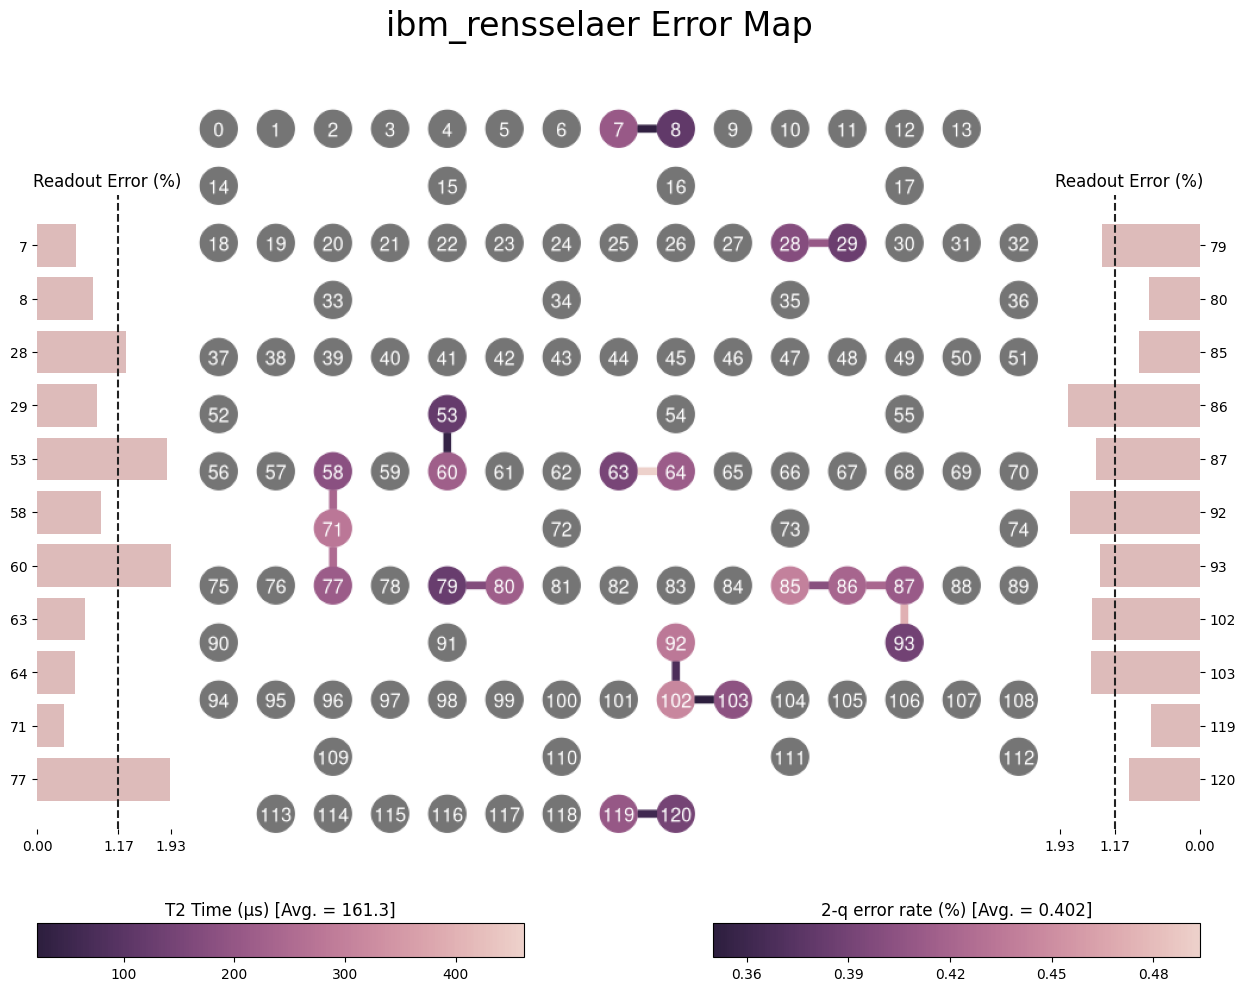

In [65]:
plot_error_map(backend, cust_cmap, qubit_coordinates = q_coords, figsize= (15,12))

Then transpile the virtual circuit to the best physical layout in this new target



In [40]:
basis_gates = list(target.operation_names)
pm = generate_preset_pass_manager(
    optimization_level=3,
    target=cust_target,
    basis_gates=basis_gates,
)

qc_trans = pm.run(qc)

print("depth", qc_trans.depth(lambda x: x[0].num_qubits == 2))
print("num 2q ops", qc_trans.count_ops())
print(
    "physical qubits",
    sorted(
        [
            idx
            for idx, qb in qc_trans.layout.initial_layout.get_physical_bits().items()
            if qb._register.name != "ancilla"
        ]
    ),
)

depth 52
num 2q ops OrderedDict([('rz', 364), ('sx', 299), ('cz', 128), ('x', 13), ('barrier', 8)])
physical qubits [2, 3, 4, 5, 16, 23, 24]


### Create PUBs for execution with Estimator



In [78]:
from qiskit import transpile
qc_trans = transpile(qc, optimization_level=3, basis_gates=['id','ecr','rz','sx','x'])

# Define observables to measure for S
observable_S_real = "I" * (n_qubits) + "X"
observable_S_imag = "I" * (n_qubits) + "Y"

observable_op_real = SparsePauliOp(
    observable_S_real
)  # define a sparse pauli operator for the observable
observable_op_imag = SparsePauliOp(observable_S_imag)

layout = qc_trans.layout  # get layout of transpiled circuit
observable_op_real = observable_op_real.apply_layout(
    layout
)  # apply physical layout to the observable
observable_op_imag = observable_op_imag.apply_layout(layout)
observable_S_real = (
    observable_op_real.paulis.to_labels()
)  # get the label of the physical observable
observable_S_imag = observable_op_imag.paulis.to_labels()

observables_S = [[observable_S_real], [observable_S_imag]]


# Define observables to measure for H
# Hamiltonian terms to measure
observable_list = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable_H_real = pauli[::-1].to_label() + "X"
    observable_H_imag = pauli[::-1].to_label() + "Y"
    observable_list.append([observable_H_real])
    observable_list.append([observable_H_imag])

layout = qc_trans.layout

observable_trans_list = []
for observable in observable_list:
    observable_op = SparsePauliOp(observable)
    observable_op = observable_op.apply_layout(layout)
    observable_trans_list.append([observable_op.paulis.to_labels()])

observables_H = observable_trans_list


# Define a sweep over parameter values
params = np.vstack(parameters).T


# Estimate the expectation value for all combinations of
# observables and parameter values, where the pub result will have
# shape (# observables, # parameter values).
pub = (qc_trans, observables_S + observables_H, params)

### Run circuits

Circuits for $t=0$ are classically calculable



In [79]:
qc_cliff = qc.assign_parameters({t: 0})


# Get expectation values from experiment
S_expval_real = StabilizerState(qc_cliff).expectation_value(
    Pauli("I" * (n_qubits) + "X")
)
S_expval_imag = StabilizerState(qc_cliff).expectation_value(
    Pauli("I" * (n_qubits) + "Y")
)

# Get expectation values
S_expval = S_expval_real + 1j * S_expval_imag

H_expval = 0
for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Get expectation values from experiment
    expval_real = StabilizerState(qc_cliff).expectation_value(
        Pauli(pauli[::-1].to_label() + "X")
    )
    expval_imag = StabilizerState(qc_cliff).expectation_value(
        Pauli(pauli[::-1].to_label() + "Y")
    )
    expval = expval_real + 1j * expval_imag

    # Fill-in matrix elements
    H_expval += coeff * expval


print(H_expval)

(-2+0j)


Execute circuits for $S$ and $\tilde{H}$ with the Estimator



In [80]:
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2

# 1. Initialize the Simulator
backend = AerSimulator()

# 2. Use the V2-compatible local estimator
estimator = BackendEstimatorV2(backend=backend)

# 3. This version correctly accepts a list of PUBs
job = estimator.run([pub])

In [ ]:
# Experiment options
# num_randomizations = 300
# num_randomizations_learning = 30
# shots_per_randomization = 100
# noise_factors = [1, 1.2, 1.4]
# learning_pair_depths = [0, 4, 24, 48]


# experimental_opts = {}
# experimental_opts["resilience"] = {
#     "measure_mitigation": True,
#     "measure_noise_learning": {
#         "num_randomizations": num_randomizations_learning,
#         "shots_per_randomization": shots_per_randomization,
#     },
#     "zne_mitigation": True,
#     "zne": {"noise_factors": noise_factors},
#     "layer_noise_learning": {
#         "max_layers_to_learn": 10,
#         "layer_pair_depths": learning_pair_depths,
#         "shots_per_randomization": shots_per_randomization,
#         "num_randomizations": num_randomizations_learning,
#     },
#     "zne": {
#         "amplifier": "pea",
#         "return_all_extrapolated": True,
#         "return_unextrapolated": True,
#         "extrapolated_noise_factors": [0] + noise_factors,
#     },
# }
# experimental_opts["twirling"] = {
#     "num_randomizations": num_randomizations,
#     "shots_per_randomization": shots_per_randomization,
#     "strategy": "all",
#     # 'strategy':'active-accum'
# }

# options = EstimatorOptions(experimental=experimental_opts)
# estimator = Estimator(mode=backend, options=options)


# job = estimator.run([pub])

thread 'thread 'thread '<unnamed><unnamed>thread '<unnamed>' panicked at ' panicked at ' panicked at <unnamed>crates/accelerate/src/euler_one_qubit_decomposer.rsthread 'crates/accelerate/src/euler_one_qubit_decomposer.rscrates/accelerate/src/euler_one_qubit_decomposer.rsthread '' panicked at :<unnamed>::crates/accelerate/src/euler_one_qubit_decomposer.rs<unnamed>' panicked at 1114crates/accelerate/src/euler_one_qubit_decomposer.rs::' panicked at :crates/accelerate/src/euler_one_qubit_decomposer.rs26::
1114called `Result::unwrap()` on an `Err` value: TargetKeyError { message: "[PhysicalQubit(44)] not in Target" }1114
::261114:
26:called `Result::unwrap()` on an `Err` value: TargetKeyError { message: "[PhysicalQubit(44)] not in Target" }:

26called `Result::unwrap()` on an `Err` value: TargetKeyError { message: "[PhysicalQubit(44)] not in Target" }1114
:
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace
note: run with `RUST_BACKTRACE=1` environment variable to

## Step 4: Post-process and return result in desired classical format



In [81]:
results = job.result()[0]

### Calculate Effective Hamiltonian and Overlap matrices

First calculate the phase accumulated by the $\vert 0 \rangle$ state during the uncontrolled time evolution



In [82]:
prefactors = [
    np.exp(-1j * sum([c for p, c in H_op.to_list() if "Z" in p]) * i * dt)
    for i in range(1, krylov_dim)
]

Once we have the results of the circuit executions we can post-process the data to calculate the matrix elements of $S$



In [83]:
# Assemble S, the overlap matrix of dimension D:
S_first_row = np.zeros(krylov_dim, dtype=complex)
S_first_row[0] = 1 + 0j

# Add in ancilla-only measurements:
for i in range(krylov_dim - 1):
    # Get expectation values from experiment
    expval_real = results.data.evs[0][0][
        i
    ]  # automatic extrapolated evs if ZNE is used
    expval_imag = results.data.evs[1][0][
        i
    ]  # automatic extrapolated evs if ZNE is used

    # Get expectation values
    expval = expval_real + 1j * expval_imag
    S_first_row[i + 1] += prefactors[i] * expval

S_first_row_list = S_first_row.tolist()  # for saving purposes


S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i, j in it.product(range(krylov_dim), repeat=2):
    if i >= j:
        S_circ[j, i] = S_first_row[i - j]
    else:
        S_circ[j, i] = np.conj(S_first_row[j - i])

In [84]:
Matrix(S_circ)

Matrix([
[                            1.0, -0.66650390625 - 0.2978515625*I, 0.25927734375 - 0.29150390625*I,     -0.0166015625000002 + 1.0*I,    -0.263671875 + 0.193359375*I],
[-0.66650390625 + 0.2978515625*I,                             1.0, -0.66650390625 - 0.2978515625*I, 0.25927734375 - 0.29150390625*I,     -0.0166015625000002 + 1.0*I],
[0.25927734375 + 0.29150390625*I, -0.66650390625 + 0.2978515625*I,                             1.0, -0.66650390625 - 0.2978515625*I, 0.25927734375 - 0.29150390625*I],
[    -0.0166015625000002 - 1.0*I, 0.25927734375 + 0.29150390625*I, -0.66650390625 + 0.2978515625*I,                             1.0, -0.66650390625 - 0.2978515625*I],
[   -0.263671875 - 0.193359375*I,     -0.0166015625000002 - 1.0*I, 0.25927734375 + 0.29150390625*I, -0.66650390625 + 0.2978515625*I,                             1.0]])

And the matrix elements of $\tilde{H}$



In [85]:
# Assemble S, the overlap matrix of dimension D:
H_first_row = np.zeros(krylov_dim, dtype=complex)
H_first_row[0] = H_expval

for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Add in ancilla-only measurements:
    for i in range(krylov_dim - 1):
        # Get expectation values from experiment
        expval_real = results.data.evs[2 + 2 * obs_idx][0][
            i
        ]  # automatic extrapolated evs if ZNE is used
        expval_imag = results.data.evs[2 + 2 * obs_idx + 1][0][
            i
        ]  # automatic extrapolated evs if ZNE is used

        # Get expectation values
        expval = expval_real + 1j * expval_imag
        H_first_row[i + 1] += prefactors[i] * coeff * expval

H_first_row_list = H_first_row.tolist()

H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i, j in it.product(range(krylov_dim), repeat=2):
    if i >= j:
        H_eff_circ[j, i] = H_first_row[i - j]
    else:
        H_eff_circ[j, i] = np.conj(H_first_row[j - i])

In [86]:
Matrix(H_eff_circ)

Matrix([
[                                -2.0,       2.72802734375 - 0.7802734375*I, -3.14111328125 + 1.1513671875*I, 0.0214843750000004 - 2.01123046875*I,  3.04345703125 - 0.752929687499999*I],
[      2.72802734375 + 0.7802734375*I,                                 -2.0,  2.72802734375 - 0.7802734375*I,      -3.14111328125 + 1.1513671875*I, 0.0214843750000004 - 2.01123046875*I],
[     -3.14111328125 - 1.1513671875*I,       2.72802734375 + 0.7802734375*I,                            -2.0,       2.72802734375 - 0.7802734375*I,      -3.14111328125 + 1.1513671875*I],
[0.0214843750000004 + 2.01123046875*I,      -3.14111328125 - 1.1513671875*I,  2.72802734375 + 0.7802734375*I,                                 -2.0,       2.72802734375 - 0.7802734375*I],
[ 3.04345703125 + 0.752929687499999*I, 0.0214843750000004 + 2.01123046875*I, -3.14111328125 - 1.1513671875*I,       2.72802734375 + 0.7802734375*I,                                 -2.0]])

Finally, we can solve the generalized eigenvalue problem for $\tilde{H}$:

$\tilde{H} \vec{c} = c S \vec{c}$

and get an estimate of the ground state energy $c_{min}$



In [87]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim + 1):
    # Solve generalized eigenvalue problem for different size of the Krylov space
    gnd_en_circ_est = solve_regularized_gen_eig(
        H_eff_circ[:d, :d], S_circ[:d, :d], threshold=9e-1
    )
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print("The estimated ground state energy is: ", gnd_en_circ_est)

The estimated ground state energy is:  -2.0
The estimated ground state energy is:  -2.4116868820077935
The estimated ground state energy is:  -4.057170668043155
The estimated ground state energy is:  -4.0650986001766425
The estimated ground state energy is:  -4.111472917508757


For a single-particle sector, we can efficiently calculate the ground state of this sector of the Hamiltonian classically



In [88]:
gs_en = single_particle_gs(H_op, n_qubits)

n_sys_qubits 3
n_exc 1 , subspace dimension 4
single particle ground state energy:  -4.0


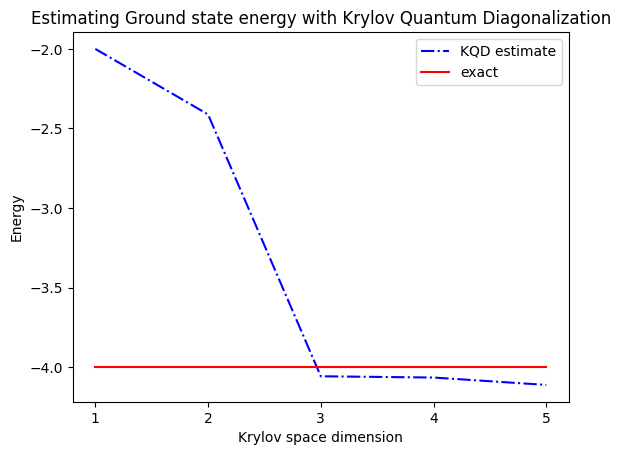

In [89]:
plt.plot(
    range(1, krylov_dim + 1),
    gnd_en_circ_est_list,
    color="blue",
    linestyle="-.",
    label="KQD estimate",
)
plt.plot(
    range(1, krylov_dim + 1),
    [gs_en] * krylov_dim,
    color="red",
    linestyle="-",
    label="exact",
)
plt.xticks(range(1, krylov_dim + 1), range(1, krylov_dim + 1))
plt.legend()
plt.xlabel("Krylov space dimension")
plt.ylabel("Energy")
plt.title(
    "Estimating Ground state energy with Krylov Quantum Diagonalization"
)
plt.show()

## Appendix: Krylov subspace from real time-evolutions

The unitary Krylov space is defined as

$$
\mathcal{K}_U(H, |\psi\rangle) = \text{span}\left\{ |\psi\rangle,  e^{-iH\,dt} |\psi\rangle, \dots, e^{-irH\,dt} |\psi\rangle \right\}
$$

for some timestep $dt$ that we will determine later. Temporarily assume $r$ is even: then define $d=r/2$. Notice that when we project the Hamiltonian into the Krylov space above, it is indistinguishable from the Krylov space

$$
\mathcal{K}_U(H, |\psi\rangle) = \text{span}\left\{ e^{i\,d\,H\,dt}|\psi\rangle,  e^{i(d-1)H\,dt} |\psi\rangle, \dots, e^{-i(d-1)H\,dt} |\psi\rangle, e^{-i\,d\,H\,dt} |\psi\rangle \right\},
$$

that is, where all the time-evolutions are shifted backward by $d$ timesteps.
The reason it is indistinguishable is because the matrix elements

$$
\tilde{H}_{j,k} = \langle\psi|e^{i\,j\,H\,dt}He^{-i\,k\,H\,dt}|\psi\rangle=\langle\psi|He^{i(j-k)H\,dt}|\psi\rangle
$$

are invariant under overall shifts of the evolution time, since the time-evolutions commute with the Hamiltonian. For odd $r$, we can use the analysis for $r-1$.

We want to show that somewhere in this Krylov space, there is guaranteed to be a low-energy state. We do so by way of the following result, which is derived from Theorem 3.1 in [\[3\]](#references):

**Claim 1:** there exists a function $f$ such that for energies $E$ in the spectral range of the Hamiltonian (that is, between the ground state energy and the maximum energy)...

1.  $f(E_0)=1$
2.  $|f(E)|\le2\left(1 + \delta\right)^{-d}$ for all values of $E$ that lie $\ge\delta$ away from $E_0$, that is, it is exponentially suppressed
3.  $f(E)$ is a linear combination of $e^{ijE\,dt}$ for $j=-d,-d+1,...,d-1,d$

We give a proof below, but that can be safely skipped unless one wants to understand the full, rigorous argument. For now we focus on the implications of the above claim. By property 3 above, we can see that the shifted Krylov space above contains the state $f(H)|\psi\rangle$. This is our low-energy state. To see why, write $|\psi\rangle$ in the energy eigenbasis:

$$
|\psi\rangle = \sum_{k=0}^{N}\gamma_k|E_k\rangle,
$$

where $|E_k\rangle$ is the kth energy eigenstate and $\gamma_k$ is its amplitude in the initial state $|\psi\rangle$. Expressed in terms of this, $f(H)|\psi\rangle$ is given by

$$
f(H)|\psi\rangle = \sum_{k=0}^{N}\gamma_kf(E_k)|E_k\rangle,
$$

using the fact that we can replace $H$ by $E_k$ when it acts on the eigenstate $|E_k\rangle$. The energy error of this state is therefore

$$
\text{energy error} = \frac{\langle\psi|f(H)(H-E_0)f(H)|\psi\rangle}{\langle\psi|f(H)^2|\psi\rangle}
$$

$$
= \frac{\sum_{k=0}^{N}|\gamma_k|^2f(E_k)^2(E_k-E_0)}{\sum_{k=0}^{N}|\gamma_k|^2f(E_k)^2}.
$$

To turn this into an upper bound that is easier to understand, we first separate the sum in the numerator into terms with $E_k-E_0\le\delta$ and terms with $E_k-E_0>\delta$:

$$
\text{energy error} = \frac{\sum_{E_k\le E_0+\delta}|\gamma_k|^2f(E_k)^2(E_k-E_0)}{\sum_{k=0}^{N}|\gamma_k|^2f(E_k)^2} + \frac{\sum_{E_k> E_0+\delta}|\gamma_k|^2f(E_k)^2(E_k-E_0)}{\sum_{k=0}^{N}|\gamma_k|^2f(E_k)^2}.
$$

We can upper bound the first term by $\delta$,

$$
\frac{\sum_{E_k\le E_0+\delta}|\gamma_k|^2f(E_k)^2(E_k-E_0)}{\sum_{k=0}^{N}|\gamma_k|^2f(E_k)^2} < \frac{\delta\sum_{E_k\le E_0+\delta}|\gamma_k|^2f(E_k)^2}{\sum_{k=0}^{N}|\gamma_k|^2f(E_k)^2} \le \delta,
$$

where the first step follows because $E_k-E_0\le\delta$ for every $E_k$ in the sum, and the second step follows because the sum in the numerator is a subset of the sum in the denominator. For the second term, first we lower bound the denominator by $|\gamma_0|^2$, since $f(E_0)^2=1$: adding everything back together, this gives

$$
\text{energy error} \le \delta + \frac{1}{|\gamma_0|^2}\sum_{E_k>E_0+\delta}|\gamma_k|^2f(E_k)^2(E_k-E_0).
$$

To simplify what is left, notice that for all these $E_k$, by the definition of $f$ we know that $f(E_k)^2 \le 4\left(1 + \delta\right)^{-2d}$. Additionally upper bounding $E_k-E_0<2\|H\|$ and upper bounding $\sum_{E_k>E_0+\delta}|\gamma_k|^2<1$ gives

$$
\text{energy error} \le \delta + \frac{8}{|\gamma_0|^2}\|H\|\left(1 + \delta\right)^{-2d}.
$$

This holds for any $\delta>0$, so if we set $\delta$ equal to our goal error, then the error bound above converges towards that exponentially with the Krylov dimension $2d=r$. Also note that if $\delta<E_1-E_0$ then the $\delta$ term actually goes away entirely in the above bound.

To complete the argument, we first note that the above is just the energy error of the particular state $f(H)|\psi\rangle$, rather than the energy error of the lowest energy state in the Krylov space. However, by the (Rayleigh-Ritz) variational principle, the energy error of the lowest energy state in the Krylov space is upper bounded by the energy error of any state in the Krylov space, so the above is also an upper bound on the energy error of the lowest energy state, that is, the output of the Krylov quantum diagonalization algorithm.

A similar analysis as the above can be carried out that additionally accounts for noise and the thresholding procedure discussed in the notebook. See [\[2\]](#references) and [\[4\]](#references) for this analysis.

## Appendix: proof of Claim 1

The following is mostly derived from [\[3\]](#references), Theorem 3.1: let $0 < a < b$ and let $\Pi^*_d$ be the space of residual polynomials (polynomials whose value at 0 is 1) of degree at most $d$. The solution to

$$
\beta(a, b, d) = \min_{p \in \Pi^*_d} \max_{x \in [a, b]} |p(x)| \quad
$$

is

$$
p^*(x) = \frac{T_d\left(\frac{b + a - 2x}{b - a}\right)}{T_d\left(\frac{b + a}{b - a}\right)}, \quad
$$

and the corresponding minimal value is

$$
\beta(a, b, d) = T_d^{-1}\left(\frac{b + a}{b - a}\right).
$$

We want to convert this into a function that can be expressed naturally in terms of complex exponentials, because those are the real time-evolutions that generate the quantum Krylov space.
To do so, it is convenient to introduce the following transformation of energies within the spectral range of the Hamiltonian to numbers in the range $[0,1]$: define

$$
g(E) = \frac{1-\cos\big((E-E_0)dt\big)}{2},
$$

where $dt$ is a timestep such that $-\pi < E_0dt < E_\text{max}dt < \pi$.
Notice that $g(E_0)=0$ and $g(E)$ grows as $E$ moves away from $E_0$.

Now using the polynomial $p^*(x)$ with the parameters a, b, d set to $a = g(E_0 + \delta)$, $b = 1$, and d = int(r/2), we define the function:

$$
f(E) = p^* \left( g(E) \right) = \frac{T_d\left(1 + 2\frac{\cos\big((E-E_0)dt\big) - \cos\big(\delta\,dt\big)}{1 +\cos\big(\delta\,dt\big)}\right)}{T_d\left(1 + 2\frac{1-\cos\big(\delta\,dt\big)}{1 + \cos\big(\delta\,dt\big)}\right)}
$$

where $E_0$ is the ground state energy. We can see by inserting $\cos(x)=\frac{e^{ix}+e^{-ix}}{2}$ that $f(E)$ is a trigonometric polynomial of degree $d$, that is, a linear combination of $e^{ijE\,dt}$ for $j=-d,-d+1,...,d-1,d$. Furthermore, from the definition of $p^*(x)$ above we have that $f(E_0)=p(0)=1$ and for any $E$ in the spectral range such that $\vert E-E_0 \vert > \delta$ we have

$$
|f(E)| \le \beta(a, b, d) = T_d^{-1}\left(1 + 2\frac{1-\cos\big(\delta\,dt\big)}{1 + \cos\big(\delta\,dt\big)}\right)
$$

$$
\leq 2\left(1 + \delta\right)^{-d} = 2\left(1 + \delta\right)^{-\lfloor k/2\rfloor}.
$$



## References

\[1] N. Yoshioka, M. Amico, W. Kirby et al. "Diagonalization of large many-body Hamiltonians on a quantum processor". [arXiv:2407.14431](https://arxiv.org/abs/2407.14431)

\[2] Ethan N. Epperly, Lin Lin, and Yuji Nakatsukasa. "A theory of quantum subspace diagonalization". SIAM Journal on Matrix Analysis and Applications 43, 1263–1290 (2022).

\[3] Å. Björck. "Numerical methods in matrix computations". Texts in Applied Mathematics. Springer International Publishing. (2014).

\[4] William Kirby. "Analysis of quantum Krylov algorithms with errors". Quantum 8, 1457 (2024).



## Tutorial survey

Please take this short survey to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_82nennpKIjjD8rQ)



© IBM Corp., 2017-2025